In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import dump
import numpy as np
from tqdm import tqdm

In [3]:
import Py_FTP_Langevin as ftp

In [4]:
k_B = 1.38066e-23    #! Boltzmann constant in (J/K)

# First time passage simulations

In [5]:
#//! *********** PARAMETERS PARTICLE PROPERTIES *********** !
MM = 28.9647  #;  //! Molecular weight of fluid molecules (kg/kmol)
Rho_p = 1800. #; //! PPs mass density
Dp = 20e-09 # Primary particle diameter (m)

#//! *********** SIMULATION PARAMETERS *********** !
N_runs = 300 #;
Box_L_factor_dmax = 1e+06 #4 #; //! Box size as factor of D_p
T_g = 1700. #;            //! Fluid temperature (K)
P_g = 101300. #;          //! Fluid pressure (Pa)
phi_p = 0.01 / 100 #;   //! Particles number concentration (1000 ppm = 0.01)    
with_collisions = True
with_rel_motion = True
with_rotation = False

#//! *********** LANGEVIN PARAMETERS *********** !
run_taus_min = 120 #; // Keep in 100 to be accurate with LD theory (otherwise the 6*D*t is not strictly respected)
LD_dt_factor = 1e-03 #;

#//! *********** PARAMETERS INT. POTENTIALS *********** !
A = 0 #2.62e-19    #;    //! Hamaker constant (J) 2.38e-19
s_LJ = 0 #0.35e-09 #5.95e-10 #; //! LJ repulsive form parameter
alpha_dp = 0.01
factor_vdw = 1 #.05
#direct = "/home/jose/Desktop/Gitlab/mitacs/mitacs_project/Python_simulations/aggregates_DLCA";
direct = "/home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info";

In [6]:
model = ftp.Pymodel(direct)
model

In [7]:
#model.Set_prop_default()
model.Set_prop(MM,Rho_p,N_runs,Box_L_factor_dmax,
               T_g,P_g,phi_p,run_taus_min,
               LD_dt_factor,A,s_LJ,alpha_dp,factor_vdw,Dp,
               with_collisions,with_rel_motion,with_rotation,direct)

In [8]:
model.Show_prop()

SIMULATION
run_taus_min:                 120
L_box/R_max                   1e+06
phi_p (ppm)                   100
Path                          /home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info
alpha_dp                      0.01
factor_vdw                    1
with_collisions               1
with_rel_motion               0
with_rotation                 0
 
FLUID PROPERTIES
Temperature (K)               1700
Pressure (Pa)                 101300
Viscosity (kg/m*s)            5.66636e-05
Fluid mfp (nm)                489.736
Maxwell avg vel (m/s)         1114.75
 
PARTICLES PROPERTIES          
Particles mean diameter (nm)  20
Hamaker constant A/(k_b*T)    0
Repuls. form param. s_LJ (m)  0
Bulk mass density (kg/m^3)    1800
 


In [9]:
ftp.Init_Random()
ftp.Make_output_folder()

In [10]:
files = ftp.get_dir_files(direct)
N_files = len(files)

In [11]:
def Export_current_sim(ftp_model,i,normalize=False):
    x1,y1,z1,r1 = ftp_model.Get_spheres(1)
    x2,y2,z2,r2 = ftp_model.Get_spheres(2)
    ofname = "ovito_out/Simulation_01.dump"
    radius = np.concatenate((r1, r2))
    if (normalize):
        nor_factor = np.mean(radius)
        radius = radius/nor_factor
    box_l = ftp_model.L_box/nor_factor
    box = ((-0.5*box_l,0.5*box_l),\
           (-0.5*box_l,0.5*box_l),\
           (-0.5*box_l,0.5*box_l))
    pos = np.array([np.concatenate((x1/nor_factor, x2/nor_factor)),
                   np.concatenate((y1/nor_factor, y2/nor_factor)),
                   np.concatenate((z1/nor_factor, z2/nor_factor))]).transpose()
    vel = pos *0
    
    N = len(x1)+len(x2)
    dump.writeOutput(ofname, N, i, box, radius=radius, pos=pos, v=vel)
    return

def run(ftp_model, model, n_steps):
    for j in range(n_steps):
        ftp_model.OneRW_step_LD(model)
    return

def isNaN(num):
    if float('-inf') < float(num) < float('inf'):
        return False 
    else:
        return True

In [12]:
i_limit = 500 * 50

In [13]:
ftp_model = ftp.PyFTP(model)

path_agg = direct + "/" + files[0].decode('utf-8')
print(path_agg)

ftp_model.Load_aggregates_external(path_agg, model)

/home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info/Agglomerate_N_000000001_Agg_00000001.dat


In [14]:
def Equilibrate(ftp_model):
    collision = ftp_model.run(model, 1000)
    return collision

def Run_simulation(model, equilib=False):
    r_sq = []
    time = []
    ftp_model.Restart_ftp(model)
    #ftp_model.show_spheres()
    #if (k == 0):
    #    ftp.Show_parameters(spheres2, model)
    ftp_model.Move_2_origin()
    ftp_model.Random_init_location()
    if(equilib):
        collision = Equilibrate(ftp_model)
    
    x2_0,y2_0,z2_0,r2 = ftp_model.Get_spheres(2)
    t_0 = ftp_model.t_res
    ftp_model.L_box = ftp_model.L_box*1e+20
    #Export_current_sim(ftp_model,0,True)
    i=1
    it_exp = 1
    collision = False
    while((not collision) and (i<i_limit)):
        collision = ftp_model.run(model, 1)
        if(isNaN(ftp_model.t_res)):
            print("d_time ",ftp_model.d_time, " t_res ",ftp_model.t_res)
            break
        x2,y2,z2,r2 = ftp_model.Get_spheres(2)
        r_sq = np.append(r_sq, np.power(x2 - x2_0,2)+\
                               np.power(y2 - y2_0,2)+\
                               np.power(z2 - z2_0,2))
        time = np.append(time, ftp_model.t_res-t_0)
        i += 1
    return time, r_sq

In [15]:
time, r_sq = Run_simulation(model)

time_sum = time
r_sq_sum = r_sq

for k in tqdm(range(1,N_runs)): #N_files):
    time_n, r_sq_n = Run_simulation(model)
    #print(time_n, r_sq_n)
    r_sq_n2 = r_sq_n #np.interp(time, time_n, r_sq_n)
    time_n2 = time_n #np.interp(r_sq, r_sq_n, time_n)
    for i in range(len(time_n2)):
        time_sum[i] += time_n2[i]
        r_sq_sum[i] += r_sq_n2[i]
r_sq = r_sq_sum/N_runs
time = time_sum/N_runs

100%|██████████████████████████████████████████████████████████████████████████████| 499/499 [04:15<00:00,  1.95it/s]


In [16]:
#ftp_model = ftp.PyFTP(model)

In [17]:
# Gas dinamic viscosity
def Mu_gas(T_g):
    mu_g = (18.203E-6)*(293.15+110)/(T_g+110)*(T_g/293.15)**(1.5)
    return mu_g
# Gas mean free path
def Lambda_gas(T_g):
    P_g = 101300
    lambda_g = 66.5E-9*(101300/P_g)*(T_g/293.15)*(1+110/293.15)/(1+110/T_g)
    return lambda_g

# Gas Knudsen number
def GET_Cc(R,T_g):
    A1 = 1.142
    A2 = 0.558
    A3 = 0.999
    lambda_g = Lambda_gas(T_g)
    Kn = lambda_g/R
    return 1+A1*Kn+A2*Kn*np.exp(-A3/Kn)

In [18]:
Cc_t = GET_Cc(0.5*Dp,T_g)
mu = Mu_gas(T_g)
f_p =3*np.pi*mu*Dp/Cc_t
m_p = np.pi/6 * np.power(Dp,3) *Rho_p
tau_p = m_p/f_p
D_p = k_B*T_g/f_p

lambda_p = np.sqrt(18*D_p*tau_p)

lambda_p*(1e+09)

450.17647428623854

In [19]:
ftp_model.show_spheres()

Particle list properties      
Np (list.size()):             1(1)
Rmax (nm)                     10
Rg (nm)                       7.74597
Rg/Rp                         0.774597
Rpp_v (nm)                    10
mean_Rp (nm)                  10
lambda_p (nm)                 418.683
m (fg)                        7.53982e-06
Kn_gas (-)                    63.2247
Kn_diff (-)                   54.0518
tau (us)                      0.0559324
tau_rot (us)                  0.0621736
tau_rot/tau                   1.11158
d_time (us)                   5.59324e-05
langevin_check                1
rotational f_r (kg*m^2/s)     4.85082e-30 (1)
translational f_t (kg/s)      1.34802e-13 (1)
f_rot/f_trans                 3.59847e-17
(x_cm, y_cm, z_cm)            0 0 0
orientation n_or              0 0 0
v_translation                 0 0 0
v_rotation                    0 0 0
relative_distance             0
F_vdW (N)                     0
F_vdW/F_grav                  0
F_vdW/F_point                 -nan
M

In [20]:
model.Show_prop()
#ftp_model.show_spheres()

SIMULATION
run_taus_min:                 120
L_box/R_max                   1e+06
phi_p (ppm)                   100
Path                          /home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info
alpha_dp                      0.01
factor_vdw                    1
with_collisions               1
with_rel_motion               0
with_rotation                 0
 
FLUID PROPERTIES
Temperature (K)               1700
Pressure (Pa)                 101300
Viscosity (kg/m*s)            5.66636e-05
Fluid mfp (nm)                489.736
Maxwell avg vel (m/s)         1114.75
 
PARTICLES PROPERTIES          
Particles mean diameter (nm)  20
Hamaker constant A/(k_b*T)    0
Repuls. form param. s_LJ (m)  0
Bulk mass density (kg/m^3)    1800
 


In [21]:
np.max(time)/(tau_p)

27.204893279548696

In [22]:
Dp_sq = Dp*Dp

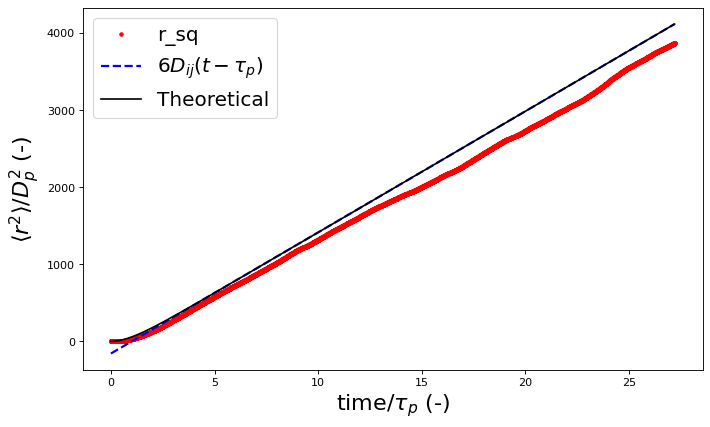

(<matplotlib.legend.Legend at 0x7fdcf38b5f70>, None)

In [23]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot((time-time[0])/tau_p, r_sq/Dp_sq,". r",label="r_sq")
if (with_rel_motion):
    D_i = ftp_model.Diff_ij
    ax1.plot((time-time[0])/tau_p, 6*D_i*(time-tau_p)/Dp_sq,"--b", linewidth=2,label="$6D_i(t-τ_p)$")
else:
    D_i = ftp_model.Diff_ij/2
    ax1.plot((time-time[0])/tau_p, 6*D_i*(time-tau_p)/Dp_sq,"--b", linewidth=2,label="$6D_{ij}(t-τ_p)$")

msd_theo = (6.*D_i*tau_p) * ((time-time[0])/tau_p -1 +np.exp(-(time-time[0])/tau_p))
ax1.plot((time-time[0])/tau_p, msd_theo/Dp_sq,"-k",label="Theoretical")
ax1.set_xlabel('time/$τ_p$ (-)', fontsize=20)
ax1.set_ylabel('$⟨r^2⟩/D_p^2$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()